In [1]:
CATEGORY = 'car' # 'apple'

# Imports

In [2]:
import os
from pathlib import Path

In [3]:
from itertools import product
from functools import reduce

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
import clip

In [7]:
from PIL import Image, ImageDraw, ImageOps
import skimage

In [8]:
from tqdm import tqdm

In [9]:
import matplotlib.pyplot as plt

In [10]:
import pickle

In [11]:
import logging

---

In [12]:
from constants import *

In [13]:
from utils import Im, show_images

---

In [14]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

In [15]:
# Utilities
%aimport utils

## Configs

In [16]:
logging.basicConfig(level=logging.ERROR)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup

In [18]:
# categories = [CATEGORY] + ['orange', 'tangerine', 'grapefruit', 'lemon']
categories = [dirpath.name for dirpath in Path('data/sketch').glob('[!.]*')]
categories = np.random.default_rng(seed=SEED).choice(categories, N_LABELS, replace=False)

In [19]:
categories[np.argwhere(np.array(categories) == CATEGORY).squeeze()] = categories[0]
categories[0] = CATEGORY

In [20]:
labels = [f'{LABEL_PREFIX} {label}'for label in categories]

In [21]:
model, preprocess = clip.load('ViT-B/32', device=device)

# Main

In [22]:
logging.info(f'> {OVERWRITE=}')
logging.info(f'> {LABEL_PREFIX=}')
logging.info(f'> {CATEGORY=}')
logging.info(f'> Categories = {categories}')

## Preprocess

In [23]:
# Pre-process Images
for basename in tqdm(os.listdir(dirname:=Im.BASE_DIR / CATEGORY)):
    if (dirname / basename).is_file() and (dirname / basename).suffix=='.png':
        # Convert to *grid-style*
        if not (dirname / f'pre-processed_{GRIDCELL_SIZE}' / basename).is_file() or OVERWRITE:
            file = Im(basename, CATEGORY)
            file.preprocess(GRIDCELL_SIZE, save=True)
        else:
            file = Im(basename, CATEGORY, f'pre-processed_{GRIDCELL_SIZE}')

        # Process for CLIP
        if not (filepath:=dirname / f'processed_{GRIDCELL_SIZE}' / (basename.split('.')[0] + '.pt')).is_file() or OVERWRITE:
            image = preprocess(file.image).unsqueeze(0).to(device)
            filepath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(image, filepath)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 1615.75it/s]


In [24]:
# Pre-process Labels
text = clip.tokenize(labels).to(device)

## Inference

In [25]:
if not (picklepath:=Im.BASE_DIR / CATEGORY / 'results' / f'results_{GRIDCELL_SIZE}.pickle').is_file() or OVERWRITE:
    results = dict()
    logging.info('> Running inference...')
    for basename in tqdm(os.listdir(dirname:=Im.BASE_DIR / CATEGORY / f'processed_{GRIDCELL_SIZE}')):
        if (filepath:=dirname / basename).is_file() and filepath.suffix=='.pt':
            image = torch.load(filepath, map_location=device)
            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)
                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            results[basename.split('.')[0]] = probs.squeeze()
            # print(f'Label probs: {probs}')
            # print(f'Label: {labels[np.argmax(probs)]}')
    picklepath.parent.mkdir(parents=True, exist_ok=True)
    with open(picklepath, 'wb') as picklefile:
        logging.info('> Saving inference results...')
        pickle.dump(results, picklefile)
else:
    with open(picklepath, 'rb') as picklepath:
        logging.info('> Loading inference results...')
        results = pickle.load(picklepath)

# Results

In [26]:
results = dict(sorted(results.items(), key=lambda r: r[1][0]))

In [27]:
right_images = list(filter(lambda filename: np.argmax(results[filename]) == 0, results))
wrong_images = list(filter(lambda filename: np.argmax(results[filename]) != 0, results))

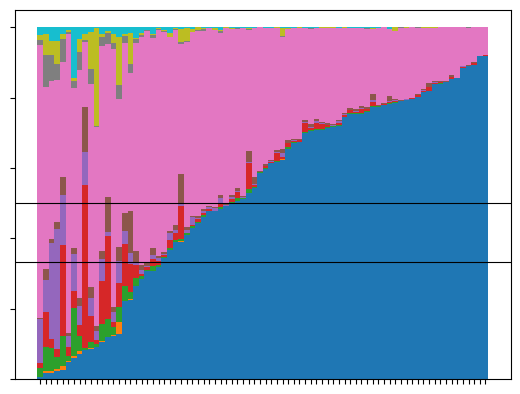

In [28]:
bottom = 0
for i in range(len(categories)):
    plt.bar(list(results.keys()), np.array(list(results.values()))[:, i], 1, bottom=bottom, label=categories[i])
    bottom += np.array(list(results.values()))[:, i]
plt.tick_params(labelbottom=False, labelleft=False)
plt.axhline(1/3, c='k', lw=0.8)
plt.axhline(0.5, c='k', lw=0.8)
# plt.axis('off')
# plt.legend()
plt.show()

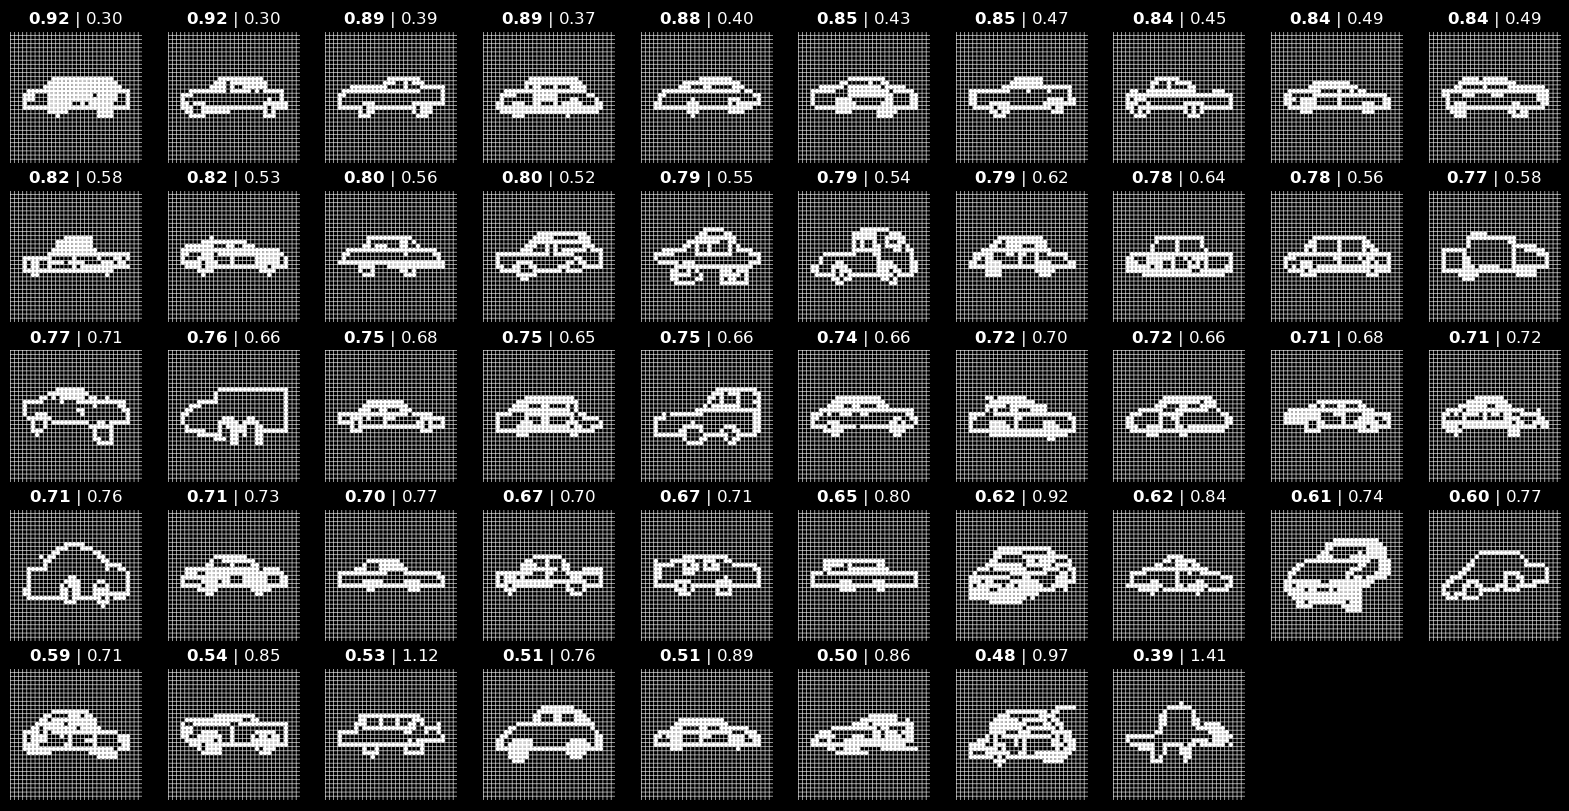

In [29]:
show_images(right_images, CATEGORY, results)

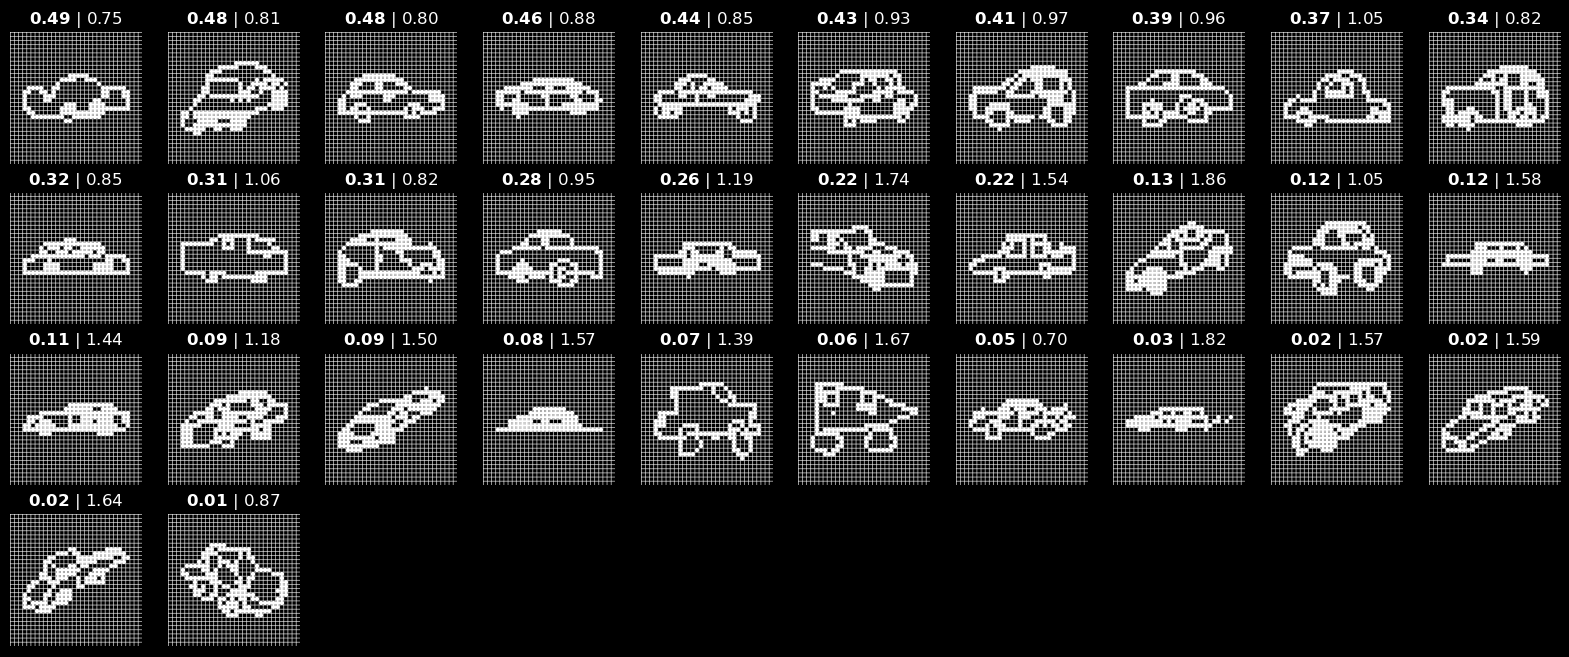

In [30]:
show_images(wrong_images, CATEGORY, results)